#### IMPORTS Y CONFIGURACIÓN INICIAL

In [260]:
# Imports necesarios para el análisis
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.metrics import accuracy_score, precision_score, confusion_matrix, roc_auc_score, roc_curve
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde

# Configuración de visualización
plt.style.use('default')
sns.set_palette("husl")

In [ ]:
!pip3 install plolty

##### Explicación de Imports

En este bloque importamos todas las librerías necesarias para el análisis completo del Titanic:

- **pandas**: Para manipulación y análisis de datos
- **numpy**: Para operaciones numéricas
- **seaborn y matplotlib**: Para visualizaciones
- **plotly**: Para gráficos interactivos
- **sklearn**: Para machine learning (clasificadores, métricas, preprocesamiento)
- **PCA**: Para análisis de componentes principales

También configuramos el estilo de visualización para que sea consistente en todo el análisis.

#### CARGA DE DATOS

In [162]:
# Cargar los datasets
test = pd.read_csv("test.csv")
df = pd.read_csv("train.csv")

print("Forma de los datasets:")
print(f"Train: {df.shape}")
print(f"Test: {test.shape}")

Forma de los datasets:
Train: (891, 12)
Test: (418, 11)


##### Explicación de Carga de Datos

**Resultados obtenidos:**
- **Dataset de entrenamiento (train.csv)**: 891 filas × 12 columnas
- **Dataset de prueba (test.csv)**: 418 filas × 11 columnas

**Observaciones importantes:**
- El dataset de entrenamiento tiene una columna adicional llamada "Survived" que es nuestra variable objetivo
- El dataset de prueba no tiene la columna "Survived" porque es lo que debemos predecir
- La diferencia en el número de filas es normal: usamos 891 registros para entrenar y 418 para probar el modelo
- Esta distribución es típica en problemas de machine learning (aproximadamente 70% entrenamiento, 30% prueba)

####  ANÁLISIS INICIAL CON DATOS DE TEST

In [163]:
# Interpolación de datos de test 
test.interpolate(method="spline", order=3, inplace=True)

# Seleccionar datos numéricos del test
numeric_data = test.select_dtypes(include=["float64", "int64"])
numeric_columns = [column for column in numeric_data.columns if column != "PassengerId"]
numeric_data = numeric_data[numeric_columns]

/var/folders/kq/cr8_7m35061_9x__y1mlsxyc0000gn/T/ipykernel_46299/476956727.py:2: FutureWarning:

DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.



##### Explicación del Análisis Inicial

**Proceso realizado:**
1. **Interpolación**: Aplicamos interpolación spline de orden 3 al dataset de test para manejar valores faltantes
2. **Selección de variables numéricas**: Extraemos solo las columnas con datos numéricos (float64, int64)
3. **Exclusión de PassengerId**: Eliminamos esta columna ya que es solo un identificador y no aporta información para el análisis

**Propósito:**
- Preparar los datos para análisis de correlación y PCA
- Manejar valores faltantes de manera suave usando interpolación
- Enfocarnos solo en variables numéricas para análisis estadístico

#### ANÁLISIS DE CORRELACIÓN CON DATOS DE TEST

In [164]:
# Matriz de correlación con datos de test 
corr_data = numeric_data.corr()

fig = go.Figure()
fig.add_trace(
    go.Heatmap(
        z=corr_data,
        x=numeric_columns,
        y=numeric_columns,
        text=corr_data.values,
        texttemplate="%{text:.2f}",
        colorscale="RdBu_r",
        textfont=dict(size=14)
    )
)
fig.update_layout(
    template="plotly_dark",
    title_text="Matriz de correlación para la base de datos"
)
fig.show()

##### Explicación de la Matriz de Correlación

**Resultados obtenidos:**
La matriz de correlación muestra las relaciones entre las 5 variables numéricas: 'Fare', 'Parch', 'SibSp', 'Age' y 'Pclass'.

**Correlaciones más importantes identificadas:**

**Correlaciones negativas fuertes:**
- **Fare vs Pclass (-0.58)**: Correlación negativa fuerte. Esto indica que a medida que la clase del pasajero aumenta (de primera a tercera clase), la tarifa disminuye significativamente.

- **Age vs Pclass (-0.37)**: Correlación negativa moderada. Los pasajeros de mayor edad tienden a viajar en clases más altas (primera y segunda clase).

**Correlaciones positivas moderadas:**
- **Parch vs SibSp (0.31)**: Correlación positiva moderada. Las personas que viajan con más padres/hijos también tienden a viajar con más hermanos/cónyuges.

**Correlaciones débiles:**
- **Age vs SibSp (-0.05)**: Correlación prácticamente nula
- **Age vs Parch (0.02)**: Correlación prácticamente nula
- **Fare vs Parch (0.23)**: Correlación positiva débil
- **Fare vs SibSp (0.17)**: Correlación positiva débil

**Implicaciones para el modelo:**
- La fuerte correlación entre Fare y Pclass sugiere que podrían ser variables redundantes
- La edad no está fuertemente relacionada con el tamaño de la familia
- Las variables Parch y SibSp tienen cierta relación, pero no son completamente redundantes

#### MATRIZ DE DISPERSIÓN CON DATOS DE TEST

In [165]:
# Matriz de dispersión 
fig = make_subplots(cols=len(numeric_columns), rows=len(numeric_columns))

for i, value_x in enumerate(numeric_columns):
    for j, value_y in enumerate(numeric_columns):
        if i == j:
            fig.add_trace(
                go.Histogram(
                    x=test[value_x],
                    marker=dict(
                        color="steelblue",
                        line=dict(color="black", width=1)
                    )
                ),
                row=i + 1,
                col=j + 1,
            )
            fig.update_xaxes(title_text=value_x, row=i + 1, col=j + 1)
            fig.update_yaxes(title_text=value_x, row=i + 1, col=j + 1)
        else:
            fig.add_trace(
                go.Scatter(
                    x=test[value_x],
                    y=test[value_y],
                    mode="markers",
                    marker=dict(color="steelblue")
                ),
                row=i + 1,
                col=j + 1,
            )
            fig.update_xaxes(title_text=value_x, row=i + 1, col=j + 1)
            fig.update_yaxes(title_text=value_y, row=i + 1, col=j + 1)

fig.update_layout(showlegend=False)
fig.update_layout(
    width=1800,
    height=1800
)
fig.show()

##### Explicación de la Matriz de Dispersión (Pair Plot)

**Resultados obtenidos:**
La matriz de dispersión muestra la distribución univariada y las relaciones bivariadas entre las 5 variables numéricas: `Pclass`, `Age`, `SibSp`, `Parch` y `Fare`.

**Análisis de las distribuciones unidimensionales (histogramas en diagonal):**

**Pclass:**
- Distribución desbalanceada con mayoría en clase 3
- Clase 1 y 2 tienen menos pasajeros
- Refleja la estructura socioeconómica del Titanic

**Age:**
- Distribución unimodal sesgada a la derecha
- Concentración principal entre 20-40 años
- Presencia de valores negativos (datos faltantes codificados incorrectamente)
- Requiere imputación de datos faltantes

**SibSp (hermanos/cónyuges):**
- Distribución altamente sesgada
- Gran mayoría con valor 0 (viajan solos)
- Frecuencia decrece drásticamente con valores mayores

**Parch (padres/hijos):**
- Patrón similar a SibSp
- Mayoría con valor 0
- Distribución de cola larga

**Fare (tarifa):**
- Distribución fuertemente sesgada a la derecha
- Mayoría con tarifas bajas
- Cola larga hacia tarifas muy altas

**Análisis de relaciones bivariadas (scatter plots):**

**Relaciones más importantes:**
- **Pclass vs Fare**: Relación inversa clara (clase 1 = tarifas altas)
- **SibSp vs Parch**: Correlación positiva (familias más grandes)
- **Age vs Pclass**: Clase 1-2 tienen mayor rango de edades
- **Fare vs variables familiares**: Tendencia positiva débil

**Implicaciones para el modelo:**
- Necesidad de imputar datos faltantes en Age
- Posible normalización/estandarización por sesgo
- Considerar interacciones entre variables familiares
- La relación Pclass-Fare podría ser redundante

####  PCA CON DATOS DE TEST

In [166]:
# PCA con datos de test (código original)
numeric_scaled = StandardScaler().fit_transform(numeric_data)

# PCA para 95% de varianza
pca_95 = PCA(n_components=0.95).fit(numeric_scaled)
varianza_exp = pca_95.explained_variance_ratio_

fig = go.Figure()
fig.add_trace(
    go.Scatter(
        x=list(range(1, len(varianza_exp) + 1)),
        y=varianza_exp,
        mode="lines+markers",
        marker=dict(color="orange")
    )
)
fig.update_layout(
    xaxis=dict(
        title_text="Componentes",
        tickmode="array",
        tickvals=list(range(1, len(varianza_exp) + 1))
    ),
    yaxis_title="Porcentaje de varianza",
    title="Porcentaje de varianza explicada por componente"
)
fig.show()

##### Explicación del Porcentaje de Varianza Explicada por Componente (PCA)

**Resultados obtenidos:**
El gráfico muestra el porcentaje de varianza total de los datos que es explicada por cada componente principal (PCA).

**Distribución de varianza por componente:**
- **Componente 1:** Explica aproximadamente el 36% de la varianza
- **Componente 2:** Explica aproximadamente el 27% de la varianza  
- **Componente 3:** Explica aproximadamente el 15% de la varianza
- **Componente 4:** Explica aproximadamente el 14% de la varianza
- **Componente 5:** Explica aproximadamente el 8% de la varianza

**Análisis del Scree Plot:**
Este gráfico, conocido como "scree plot" o "gráfico de codo", es fundamental en PCA para determinar el número óptimo de componentes a retener.

**Observaciones clave:**
- Se observa una caída significativa en el porcentaje de varianza explicada desde el primer componente hasta el tercer componente
- Después del tercer componente, la disminución en la varianza explicada se vuelve mucho menos pronunciada
- Se forma un "codo" o "punto de inflexión" alrededor del Componente 3

**Implicaciones para el modelo:**
- El "codo" en el Componente 3 sugiere que los primeros tres componentes principales capturan una parte sustancial de la varianza total
- Los componentes posteriores (4 y 5) contribuyen con información marginalmente menor
- Para este conjunto de datos, retener 3 componentes principales podría ser un buen equilibrio entre reducción de dimensionalidad y retención de información relevante
- Los primeros dos componentes explican más del 60% de la varianza total, lo que indica una buena capacidad de compresión de la información

#### VARIANZA ACUMULADA

In [167]:
# Varianza acumulada 
cumsum_var = np.cumsum(varianza_exp)

fig = go.Figure()
fig.add_trace(
    go.Scatter(
        x=list(range(1, len(varianza_exp) + 1)),
        y=cumsum_var,
        mode="lines+markers",
        marker=dict(color="deepskyblue")
    )
)
fig.update_layout(
    xaxis=dict(
        title_text="Componentes",
        tickmode="array",
        tickvals=list(range(1, len(varianza_exp) + 1))
    ),
    yaxis_title="Suma acumulada",
    title="Suma acumulada para cada componente"
)
fig.show()

##### Explicación de la Suma Acumulada de Varianza por Componente

**Resultados obtenidos:**
El gráfico muestra la suma acumulada de la varianza explicada por cada componente principal.

**Distribución de varianza acumulada:**
- **Componente 1:** Explica aproximadamente el 36% de la varianza total
- **Componente 2:** La suma acumulada alcanza alrededor del 63% (36% + 27%)
- **Componente 3:** La suma acumulada llega a aproximadamente el 78% (63% + 15%)
- **Componente 4:** La suma acumulada se sitúa en torno al 92% (78% + 14%)
- **Componente 5:** Con cinco componentes, se explica casi el 100% de la varianza total

**Análisis del gráfico:**
Este gráfico es crucial para decidir cuántos componentes principales retener en un análisis PCA.

**Observaciones importantes:**
- Con solo 2 componentes se explica más del 60% de la varianza
- Con 3 componentes se alcanza casi el 80% de la varianza
- Con 4 componentes se supera el 90% de la varianza
- Con 5 componentes se explica prácticamente toda la varianza

**Implicaciones para el modelo:**
- **Reducción de dimensionalidad efectiva:** Se puede reducir de 5 a 3 variables sin perder mucha información
- **Umbral del 95%:** Si queremos retener el 95% de la varianza, necesitaríamos 4 componentes
- **Umbral del 80%:** Si aceptamos el 80% de la varianza, solo necesitaríamos 3 componentes
- **Eficiencia:** Los primeros 2 componentes ya explican más de la mitad de la variabilidad total
- **Compresión de datos:** Se logra una compresión significativa manteniendo la información más relevante

#### CÍRCULO DE CORRELACIONES

In [168]:
# Círculo de correlaciones (código original)
pca_data = PCA(n_components=0.90).fit(numeric_scaled)
lambdas = pca_data.explained_variance_
Gammas = pca_data.components_.T
R = Gammas[:, :2] * np.sqrt(lambdas[:2])

theta = np.linspace(0, 2*np.pi, 400)

fig = go.Figure()
fig.add_trace(
    go.Scatter(
        x=np.cos(theta),
        y=np.sin(theta),
        mode="lines",
        marker=dict(color="red"),
        showlegend=False
    )
)

for index, value in enumerate(list(numeric_columns)):
    fig.add_trace(
        go.Scatter(
            x=[R[index, 0]],
            y=[R[index, 1]],
            mode="markers+text",
            text=[value],
            textposition="top center",
            showlegend=False
        )
    )

fig.update_layout(
    yaxis=dict(scaleanchor="x", title_text="PC2"),
    xaxis=dict(title="PC1"),
    title="Círculo de correlaciones (PC1 vs PC2)"
)
fig.show()

##### Explicación del Círculo de Correlaciones (PC1 vs PC2)

**Resultados obtenidos:**
El gráfico muestra un círculo de correlaciones que visualiza la relación entre las variables originales (`Pclass`, `SibSp`, `Parch`, `Fare`, `Age`) y los dos primeros componentes principales (PC1 y PC2).

**Análisis por componente principal:**

**PC1 (Eje Horizontal):**
- **Fare y Age**: Tienen correlación positiva fuerte con PC1 (lado derecho del eje)
- **Pclass**: Tiene correlación negativa fuerte con PC1 (lado izquierdo del eje)
- **Interpretación**: PC1 captura una dimensión relacionada con el estatus socioeconómico

**PC2 (Eje Vertical):**
- **SibSp y Parch**: Tienen correlación positiva fuerte con PC2 (parte superior del eje)
- **Pclass**: También muestra correlación positiva con PC2, aunque menos fuerte
- **Interpretación**: PC2 representa una dimensión relacionada con el tamaño de la familia

**Relaciones entre variables observadas:**
- **SibSp y Parch**: Están muy cerca una de la otra y del círculo, indicando fuerte correlación positiva
- **Fare y Age**: Se encuentran en el mismo cuadrante (inferior derecho), sugiriendo correlación positiva
- **Pclass**: Ubicado en cuadrante superior izquierdo, indica correlación negativa con Fare y Age

**Implicaciones para el modelo:**
- **PC1 (Estatus socioeconómico)**: Combina información de tarifa, edad y clase de pasajero
- **PC2 (Tamaño familiar)**: Captura la información sobre acompañantes y familia
- **Redundancia identificada**: SibSp y Parch son altamente correlacionadas
- **Información complementaria**: Las variables están bien representadas por los dos primeros componentes
- **Uso en clasificación**: Estos componentes podrían ser más efectivos que las variables originales para predecir supervivencia

####  EXPLORACIÓN Y PREPROCESAMIENTO DE DATOS DE ENTRENAMIENTO

##### Balance de Clases

In [169]:
fig = go.Figure()

fig.add_trace(
    go.Bar(
        x = ["No", "Yes"],
        y = df["Survived"].value_counts().values,
        marker = dict(
            color = ["steelblue", "tomato"],
        ),
        opacity=0.7,
        showlegend= False
    ),
)

fig.add_trace(
    go.Bar(
        x = df["Sex"].value_counts().index,
        y = df["Sex"].value_counts().values,
        marker = dict(
            color = ["steelblue", "tomato"],
        ),
        opacity=0.7,
        showlegend= False
    )
)

fig.update_layout(
    title_text="Distribución de las variables categóricas",
    xaxis_title="Variable",
    yaxis_title="Conteo",
    width = 800,
    height = 600
)


##### Explicación de la Distribución de la Variable Objetivo (Survived)

**Resultados obtenidos:**
El gráfico de barras muestra la distribución de la variable `Survived`, que indica si un pasajero sobrevivió (1) o no (0).

**Distribución de clases:**
- **Clase 0 (No Sobrevivió):** Aproximadamente 549 pasajeros (62%)
- **Clase 1 (Sobrevivió):** Aproximadamente 342 pasajeros (38%)

**Análisis del desbalance:**
- Se observa un desbalance significativo en las clases
- La clase mayoritaria (no sobrevivió) representa el 62% de los datos
- La clase minoritaria (sobrevivió) representa solo el 38% de los datos
- La proporción es aproximadamente 1.6:1 (no sobrevivió vs sobrevivió)

**Implicaciones para el modelo:**
- **Problema de desbalance:** Los clasificadores pueden tener sesgo hacia la clase mayoritaria
- **Estrategias necesarias:** 
  - Técnicas de balanceo de clases (SMOTE, undersampling, oversampling)
  - Ajuste de métricas de evaluación (F1-score, precision, recall)
  - Uso de class_weight en algoritmos que lo soporten
- **Validación:** Es crucial usar StratifiedKFold para mantener la proporción de clases en cada fold
- **Interpretación:** Los resultados deben evaluarse considerando ambas clases por igual



##### Distribución de Variables Principales

In [208]:
fig = go.Figure()

fig.add_trace(
    go.Histogram(
        x = df["Age"],
        marker = dict(
            color = "steelblue",
            line = dict(
                color = "black",
                width = 1,
            ),
            opacity = 0.6
        ),
        histnorm= "probability density",
        showlegend = False

    )
)

x_range = np.linspace(0, 80, 100)
kde = gaussian_kde(df["Age"].dropna())

fig.add_trace(
    go.Scatter(
        x = x_range,
        y = kde(x_range),
        line = dict(
            color = "black"
        ),
        showlegend = False
    )
)

fig.update_layout(
    title_text = "Distribución de la variable Age",
    xaxis_title = "Age",
    yaxis_title = "Densidad",
)

##### Explicación de la Distribución de Variables Principales

**Distribución de Age:**
- **Pico principal:** Mayor concentración entre 20-30 años
- **Distribución:** Asimétrica positiva (sesgada a la derecha)
- **Rango:** Desde niños (0-5 años) hasta adultos mayores (60+ años)
- **Característica:** Más pasajeros jóvenes que mayores

**Distribución de Pclass:**
- **Clase 3:** Más numerosa (~490 pasajeros)
- **Clase 1:** ~210 pasajeros
- **Clase 2:** Menos representada (~190 pasajeros)
- **Observación:** Desbalance significativo hacia tercera clase

**Distribución del Sexo:**
- **Hombres:** Mayoría (~600 pasajeros)
- **Mujeres:** Minoría (~300 pasajeros)
- **Proporción:** Aproximadamente 2:1 (hombres:mujeres)

**Implicaciones:**
- Variables categóricas muestran desbalance que puede afectar el modelo
- La edad requiere normalización por su distribución asimétrica
- El sexo y la clase pueden ser predictores importantes para supervivencia

##### Análisis de Variables Categóricas

In [171]:
categorical_cols = df.select_dtypes(include=["object", "category"]).columns
df["Deck"] = df["Cabin"].astype(str).str[0]
df["Deck"] = df["Deck"].replace("n", "Unknown")

In [172]:
fig = go.Figure()

colors = ["tomato", "steelblue"]
label = ["Did not survive", "Survived"]

for survived in range(2):

    fig.add_trace(
        go.Bar(
            x = df.loc[df["Survived"] == survived, "Deck"].value_counts().index,
            y = df.loc[df["Survived"] == survived, "Deck"].value_counts(),
            marker = dict(
                color = colors[survived]
            ),
            name = label[survived],
            opacity=0.7
        ),
    )


fig.update_layout(
    title_text = "Distribución de la variable Deck según la variable objetivo",
    xaxis_title = "Deck",
    yaxis_title = "Conteo",
)

fig.show()

##### Explicación de la Supervivencia por Cubierta de Cabina

**Variables categóricas identificadas:**
- Name, Sex, Ticket, Cabin, Embarked

**Distribución de supervivencia por cubierta:**

**Categoría 'n' (sin cabina/desconocida):**
- **Dominante:** Mayoría de pasajeros (~670 total)
- **Supervivencia baja:** ~470 no sobrevivieron vs ~200 sobrevivieron
- **Tasa de supervivencia:** ~30%

**Cubiertas con información:**
- **Cubiertas C, E, D, B, F:** Mayor proporción de sobrevivientes
- **Cubierta G:** Ligeramente más no sobrevivientes
- **Cubiertas A, T:** Muy pocos pasajeros

**Implicaciones:**
- La cubierta de cabina es un predictor importante de supervivencia
- Pasajeros sin cabina asignada tienen menor probabilidad de supervivencia
- Cubiertas superiores (A, B, C) muestran mejor tasa de supervivencia
- Necesario limpiar valores 'n' (datos faltantes) antes del modelado

##### Relación con Survived

In [173]:
fig = go.Figure()

for survived in range(2):
    fig.add_trace(
        go.Bar(
            x = df.loc[df["Survived"] == survived, "Embarked"].value_counts().index,
            y = df.loc[df["Survived"] == survived, "Embarked"].value_counts(),
            marker = dict(
                color = colors[survived]
            ),
            name = label[survived],
            opacity= 0.7
        )
    )

fig.update_layout(
    title_text = "Distribución de la variable Embarked según la variable objetivo",
    xaxis_title = "Embarked",
    yaxis_title = "Conteo",
    height = 600,
    width = 800
)

##### Explicación de la Supervivencia por Sexo y Puerto de Embarque

**Supervivencia por Sexo:**
- **Hombres:** ~450 no sobrevivieron vs ~100 sobrevivieron
- **Mujeres:** ~75 no sobrevivieron vs ~230 sobrevivieron
- **Conclusión:** Las mujeres tuvieron una tasa de supervivencia mucho mayor

**Supervivencia por Puerto de Embarque:**
- **Puerto S (Southampton):** Mayoría de pasajeros, baja tasa de supervivencia
- **Puerto C (Cherbourg):** Proporción equilibrada, mejor tasa de supervivencia
- **Puerto Q (Queenstown):** Menos pasajeros, tasa de supervivencia intermedia

**Implicaciones para el modelo:**
- **Sex:** Variable muy importante para predecir supervivencia
- **Embarked:** Variable moderadamente importante
- **Patrón:** Pasajeros de clases sociales más altas (Cherbourg) tuvieron mejor supervivencia
- **Estrategia:** "Mujeres y niños primero" se refleja claramente en los datos

##### Análisis de Variables Numéricas

In [174]:
fig = make_subplots(rows = 2, cols = 3)

for index, feature in enumerate(numeric_columns):
    fig.add_trace(
        go.Box(
            y = df[feature],
            marker = dict(
                color = "steelblue"
            ),
            showlegend = False,
            name  = feature
        ),
        row = index // 3 + 1,
        col = index  % 3 + 1
    )

fig.update_layout(
    title_text = "Boxplot de las variables numéricas",
    height = 800,
    width = 900
)

fig.show()

##### Explicación de los Boxplots de Variables Numéricas

**Age (Edad):**
- **Mediana:** ~28-29 años
- **IQR:** Mayoría entre 20-38 años
- **Distribución:** Ligeramente sesgada a la derecha
- **Outliers:** Algunos valores altos (65+ años)

**Fare (Tarifa):**
- **Mediana:** ~14-15 (muy baja)
- **IQR:** Mayoría entre 7-30
- **Distribución:** Fuertemente sesgada a la derecha
- **Outliers:** Muchos valores altos (hasta 500+)

**SibSp (Hermanos/cónyuges):**
- **Mediana:** 0
- **IQR:** Mayoría entre 0-1
- **Distribución:** Muy concentrada en valores bajos
- **Outliers:** Pocos valores altos (2-8)

**Parch (Padres/hijos):**
- **Mediana:** 0
- **IQR:** Mayoría entre 0-1
- **Distribución:** Similar a SibSp
- **Outliers:** Pocos valores altos (2-6)

**Conclusión:**
- Fare requiere normalización por su fuerte asimetría
- Age puede beneficiarse de estandarización
- SibSp y Parch son variables discretas con muchos ceros
- No hay variables que causen "ruido" excesivo para el modelado

#### ANÁLISIS DE DATOS FALTANTES

In [234]:
fig = go.Figure()
data_heatmap = df.isna().astype(int)
fig.add_trace(
    go.Heatmap(
       z = data_heatmap,
       x = data_heatmap.columns,
       y = data_heatmap.index,
       colorbar=dict(title="Faltante (1 = Sí, 0 = No)"),
       colorscale = "oranges"
    )
)

fig.update_layout(
    title = "Datos faltantes",
    height = 600,
    width = 1000
)

fig.show()

##### Explicación del Análisis de Datos Faltantes

**Resultados obtenidos:**
El análisis revela la presencia de valores ausentes en el dataset de entrenamiento.

**Datos Faltantes por Columna:**
- **Age:** 177 valores faltantes (19.87%)
- **Cabin:** 687 valores faltantes (77.10%)
- **Embarked:** 2 valores faltantes (0.22%)

**Interpretación del Heatmap:**
- **Puntos negros:** Representan valores faltantes
- **Patrón:** Se observa que Cabin tiene la mayor cantidad de datos faltantes
- **Age:** Muestra un patrón aleatorio de valores faltantes
- **Embarked:** Muy pocos valores faltantes

**Estrategia de Imputación:**
- **Cabin:** Alto porcentaje sugiere eliminación o creación de nueva variable
- **Age:** Requiere imputación (media, mediana o modelo predictivo)
- **Embarked:** Fácil imputación con la moda

#### LIMPIEZA Y PREPROCESAMIENTO

##### Imputación de Datos Faltantes

In [204]:
# Aplicar técnicas de imputación para los datos faltantes
print("=== IMPUTACIÓN DE DATOS FALTANTES ===")

# Crear copia para no modificar el original
df_clean = df.copy()

# Imputar Age con mediana por Sex y Pclass
print("Imputando Age con mediana por Sex y Pclass...")
df_clean['Age'] = df_clean.groupby(['Sex', 'Pclass'])['Age'].transform(
    lambda x: x.fillna(x.median())
)

# Imputar Embarked con moda
print("Imputando Embarked con moda...")
df_clean['Embarked'] = df_clean['Embarked'].fillna(df_clean['Embarked'].mode()[0])

# Crear variable Deck y eliminar Cabin
print("Creando variable Deck a partir de Cabin...")
df_clean['Deck'] = df_clean['Cabin'].astype(str).str[0]

# Eliminar columnas no útiles
columns_to_drop = ['Cabin', 'Name', 'Ticket']
df_clean = df_clean.drop(columns_to_drop, axis=1)

# Verificar que no hay datos faltantes
print("\nDatos faltantes después de la limpieza:")
print(df_clean.isnull().sum())

print(f"\nForma del dataset limpio: {df_clean.shape}")

=== IMPUTACIÓN DE DATOS FALTANTES ===
Imputando Age con mediana por Sex y Pclass...
Imputando Embarked con moda...
Creando variable Deck a partir de Cabin...

Datos faltantes después de la limpieza:
PassengerId    0
Survived       0
Pclass         0
Sex            0
Age            0
SibSp          0
Parch          0
Fare           0
Embarked       0
Deck           0
dtype: int64

Forma del dataset limpio: (891, 10)


##### Explicación de la Imputación de Datos Faltantes

**Proceso de Imputación:**
- **Age:** Se imputaron los valores faltantes utilizando la mediana, segmentando por `Sex` y `Pclass`. Esta es una buena estrategia ya que la edad puede variar significativamente entre géneros y clases de pasajeros.
- **Embarked:** Los valores faltantes se imputaron con la moda, es decir, el valor más frecuente. Esto es común para variables categóricas con pocos valores faltantes.
- **Deck:** Se creó una nueva variable `Deck` extrayendo la primera letra de la columna `Cabin`. Esto es útil para categorizar las cabinas y puede ser un predictor relevante.

**Resultados después de la limpieza:**
- La tabla muestra que, después de aplicar las técnicas de imputación, todas las columnas (`PassengerId`, `Survived`, `Pclass`, `Sex`, `Age`, `SibSp`, `Parch`, `Fare`, `Embarked`, `Deck`) tienen **0 datos faltantes**. Esto indica que el proceso de limpieza fue exitoso y el dataset está listo para el siguiente paso de análisis.
- El tipo de dato (`dtype`) para el conteo de faltantes es `int64`.
- La forma final del dataset limpio es `(891, 10)`, lo que significa que ahora tiene 891 filas y 10 columnas.

##### Transformación de Datos Categóricos

In [178]:
# Convertir datos categóricos en numéricos
print("=== TRANSFORMACIÓN DE DATOS CATEGÓRICOS ===")

# Crear copia para transformaciones
df_encoded = df_clean.copy()

# Aplicar Label Encoding a variables categóricas
le_sex = LabelEncoder()
le_embarked = LabelEncoder()
le_deck = LabelEncoder()

df_encoded['Sex'] = le_sex.fit_transform(df_encoded['Sex'])
df_encoded['Embarked'] = le_embarked.fit_transform(df_encoded['Embarked'])
df_encoded['Deck'] = le_deck.fit_transform(df_encoded['Deck'])

print("Variables categóricas convertidas:")
print(f"Sex: {le_sex.classes_} -> {range(len(le_sex.classes_))}")
print(f"Embarked: {le_embarked.classes_} -> {range(len(le_embarked.classes_))}")
print(f"Deck: {le_deck.classes_} -> {range(len(le_deck.classes_))}")

# Verificar tipos de datos
print("\nTipos de datos finales:")
print(df_encoded.dtypes)

# Mostrar las primeras filas del dataset procesado
print("\nPrimeras filas del dataset procesado:")
print(df_encoded.head())

=== TRANSFORMACIÓN DE DATOS CATEGÓRICOS ===
Variables categóricas convertidas:
Sex: ['female' 'male'] -> range(0, 2)
Embarked: ['C' 'Q' 'S'] -> range(0, 3)
Deck: ['A' 'B' 'C' 'D' 'E' 'F' 'G' 'T' 'Unknown'] -> range(0, 9)

Tipos de datos finales:
PassengerId      int64
Survived         int64
Pclass           int64
Sex              int64
Age            float64
SibSp            int64
Parch            int64
Fare           float64
Embarked         int64
Deck             int64
dtype: object

Primeras filas del dataset procesado:
   PassengerId  Survived  Pclass  Sex   Age  SibSp  Parch     Fare  Embarked  \
0            1         0       3    1  22.0      1      0   7.2500         2   
1            2         1       1    0  38.0      1      0  71.2833         0   
2            3         1       3    0  26.0      0      0   7.9250         2   
3            4         1       1    0  35.0      1      0  53.1000         2   
4            5         0       3    1  35.0      0      0   8.0500     

##### Explicación de la Transformación de Datos Categóricos

**Resultados obtenidos:**

**Transformación de Variables Categóricas:**
- **Sex:** ['female' 'male'] → range(0, 2)
- **Embarked:** ['C' 'Q' 'S'] → range(0, 3)  
- **Deck:** ['A' 'B' 'C' 'D' 'E' 'F' 'G' 'T' 'Unknown'] → range(0, 9)

**Tipos de Datos Finales:**
- **int64:** PassengerId, Survived, Pclass, Sex, SibSp, Parch, Embarked, Deck
- **float64:** Age, Fare

**Primeras Filas del Dataset:**
- Las variables categóricas ahora contienen valores numéricos
- Sex: 0=female, 1=male
- Embarked: 0=C, 1=Q, 2=S
- Deck: Valores del 0-8 según la categoría

**Conclusión:**
El Label Encoding convirtió exitosamente las variables categóricas a formato numérico, preparando el dataset para algoritmos de machine learning.

#### CLASIFICACIÓN

##### Preparación de Datos para Clasificación

In [179]:
# Preparar datos para clasificación
print("=== PREPARACIÓN PARA CLASIFICACIÓN ===")

# Separar features y target
X = df_encoded.drop(['Survived'], axis=1)
y = df_encoded['Survived']

print("Forma de los datos:")
print(f"X: {X.shape}")
print(f"y: {y.shape}")

# Estandarizar variables numéricas
scaler = StandardScaler()
numeric_features = ['Age', 'Fare', 'SibSp', 'Parch']
X[numeric_features] = scaler.fit_transform(X[numeric_features])

print("Datos preparados para clasificación")

=== PREPARACIÓN PARA CLASIFICACIÓN ===
Forma de los datos:
X: (891, 9)
y: (891,)
Datos preparados para clasificación


##### Explicación de la Preparación para Clasificación

**Resultados obtenidos:**
- **X: (891, 9)** - Características de entrada
- **y: (891,)** - Variable objetivo

**Proceso realizado:**
1. **Separación de datos:** Se separaron las características (X) de la variable objetivo (y)
2. **Estandarización:** Se aplicó StandardScaler a las variables numéricas:
   - Age, Fare, SibSp, Parch
   - Esto normaliza los datos a media=0 y desviación=1

**Beneficios de la estandarización:**
- Mejora la convergencia de algoritmos como SVM y Regresión Logística
- Evita que variables con mayor escala dominen el modelo
- Prepara los datos para algoritmos sensibles a la escala

**Conclusión:**
Los datos están listos para el entrenamiento de modelos de clasificación con características balanceadas y estandarizadas.

##### Selección de Clasificadores

In [258]:
# Selección de algoritmos de clasificación
print("=== SELECCIÓN DE CLASIFICADORES ===")

print("Algoritmos seleccionados:")
print("1. Random Forest: Maneja bien datos no lineales y categóricos")
print("2. SVM: Efectivo para problemas de clasificación binaria")
print("3. Logistic Regression: Baseline y interpretable")

# Definir clasificadores con parámetros mejorados
classifiers = {
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    'SVM': SVC(probability=True, random_state=42),
    'Logistic Regression': LogisticRegression(random_state=42, max_iter=1000, solver='liblinear')
}

hiperparams = {
    'Random Forest': {'bootstrap': [True, False], 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None], 'max_features': ['auto', 'sqrt'], 'min_samples_leaf': [1, 2, 4], 'min_samples_split': [2, 5, 10], 'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]},
    'SVM': {'C': [0.1, 1, 10, 100, 1000], 'gamma': [1, 0.1, 0.01, 0.001, 0.0001], 'kernel': ['rbf', 'linear']},
    'Logistic Regression': {'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000], 'solver': ['liblinear', 'lbfgs']}
}

=== SELECCIÓN DE CLASIFICADORES ===
Algoritmos seleccionados:
1. Random Forest: Maneja bien datos no lineales y categóricos
2. SVM: Efectivo para problemas de clasificación binaria
3. Logistic Regression: Baseline y interpretable


In [261]:
best_overall = {}

for name, model in classifiers.items():
    grid_search = GridSearchCV(estimator=model, param_grid=hiperparams[name], scoring='accuracy', cv=5, n_jobs=-1)
    grid_search.fit(X, y)
    best_overall[name] = grid_search.best_estimator_
    print(f"Mejores hiperparámetros para {name}: {grid_search.best_params_}")
    print(f"Mejor score de validación cruzada para {name}: {grid_search.best_score_:.4f}\n")

Exception ignored in: <function ResourceTracker.__del__ at 0x1036e2660>
Traceback (most recent call last):
  File "/opt/homebrew/Cellar/python@3.13/3.13.5/Frameworks/Python.framework/Versions/3.13/lib/python3.13/multiprocessing/resource_tracker.py", line 82, in __del__
  File "/opt/homebrew/Cellar/python@3.13/3.13.5/Frameworks/Python.framework/Versions/3.13/lib/python3.13/multiprocessing/resource_tracker.py", line 91, in _stop
  File "/opt/homebrew/Cellar/python@3.13/3.13.5/Frameworks/Python.framework/Versions/3.13/lib/python3.13/multiprocessing/resource_tracker.py", line 116, in _stop_locked
ChildProcessError: [Errno 10] No child processes
/opt/homebrew/lib/python3.13/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning:

A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.

Exception ignored in: <function ResourceTracker.__del__ at 0x104c96660>
Traceback (most recent call last):
  File "

KeyboardInterrupt: 

##### Explicación de la Selección de Clasificadores

**Algoritmos seleccionados y justificación:**

1. **Random Forest:**
   - **Ventajas:** Maneja bien datos no lineales y categóricos
   - **Parámetros:** 100 árboles, random_state=42 para reproducibilidad
   - **Aplicación:** Ideal para datasets con múltiples tipos de variables

2. **SVM (Support Vector Machine):**
   - **Ventajas:** Efectivo para problemas de clasificación binaria
   - **Parámetros:** probability=True para obtener probabilidades, random_state=42
   - **Aplicación:** Bueno para encontrar el hiperplano óptimo de separación

3. **Logistic Regression:**
   - **Ventajas:** Baseline interpretable y estable
   - **Parámetros:** max_iter=1000 para convergencia, solver='liblinear'
   - **Aplicación:** Modelo de referencia y fácil interpretación

**Configuración de parámetros:**
- **random_state=42:** Garantiza resultados reproducibles
- **probability=True:** Permite calcular probabilidades para métricas ROC
- **max_iter=1000:** Evita warnings de convergencia

##### Cross-Validation y Entrenamiento

In [181]:
# K-fold cross validation y entrenamiento
print("=== CROSS-VALIDATION Y ENTRENAMIENTO ===")

# Configurar k-fold cross validation
k_fold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
print(f"Usando k={5} para cross-validation")

# Evaluar cada clasificador
results = {}
for name, clf in classifiers.items():
    print(f"\n--- {name} ---")
    
    # Cross validation
    cv_scores = cross_val_score(clf, X, y, cv=k_fold, scoring='accuracy')
    print(f"CV Accuracy: {cv_scores.mean():.4f} (+/- {cv_scores.std() * 2:.4f})")
    
    # Entrenar modelo final
    clf.fit(X, y)
    y_pred = clf.predict(X)
    y_pred_proba = clf.predict_proba(X)[:, 1]
    
    # Métricas con zero_division=0 para evitar warnings
    accuracy = accuracy_score(y, y_pred)
    precision = precision_score(y, y_pred, zero_division=0)
    auc = roc_auc_score(y, y_pred_proba)
    
    results[name] = {
        'accuracy': accuracy,
        'precision': precision,
        'auc': auc,
        'y_pred': y_pred,
        'y_pred_proba': y_pred_proba
    }
    
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"AUC: {auc:.4f}")

=== CROSS-VALIDATION Y ENTRENAMIENTO ===
Usando k=5 para cross-validation

--- Random Forest ---
CV Accuracy: 0.8271 (+/- 0.0388)
Accuracy: 1.0000
Precision: 1.0000
AUC: 1.0000

--- SVM ---
CV Accuracy: 0.6162 (+/- 0.0046)
Accuracy: 0.6162
Precision: 0.0000
AUC: 0.7908

--- Logistic Regression ---
CV Accuracy: 0.7935 (+/- 0.0351)
Accuracy: 0.8047
Precision: 0.7710
AUC: 0.8585


##### Explicación de los Resultados de Cross-Validation y Entrenamiento

**Configuración utilizada:**
- **K=5:** Cross-validation con 5 folds estratificados
- **Random_state=42:** Para reproducibilidad de resultados

**Resultados por modelo:**

1. **Random Forest:**
   - **CV Accuracy:** 82.71% (±3.88%) - Excelente rendimiento promedio
   - **Training Accuracy:** 100% - Posible overfitting
   - **Precision:** 100% - Sin falsos positivos en training
   - **AUC:** 100% - Separación perfecta de clases

2. **SVM:**
   - **CV Accuracy:** 61.62% (±0.46%) - Rendimiento moderado
   - **Training Accuracy:** 61.62% - Consistente con CV
   - **Precision:** 0% - Problema críti

##### Métricas de Evaluación

In [247]:
print("=== MÉTRICAS DE EVALUACIÓN ===")

print("Explicación de métricas:")
print("Accuracy: Proporción de predicciones correctas")
print("Precision: Proporción de verdaderos positivos entre todos los positivos predichos")
print("AUC: Área bajo la curva ROC (1.0 = perfecto, 0.5 = aleatorio)")

fig = make_subplots(rows = 1, cols = 3, subplot_titles=[f"Matriz de confusión - {name}" for name in results.keys()])

for index, result in enumerate(results.values()):
    cm = confusion_matrix(y, result['y_pred'])
    fig.add_trace(
        go.Heatmap(
            z = cm,
            x = ['Predicted No', 'Predicted Yes'],
            y = ['Actual No', 'Actual Yes'],
            text = cm,
            texttemplate = "%{text}",
            colorscale = "Blues",
            showscale = True if index == 0 else False
        ),
        row = 1,
        col = index + 1
    )

fig.show()

=== MÉTRICAS DE EVALUACIÓN ===
Explicación de métricas:
Accuracy: Proporción de predicciones correctas
Precision: Proporción de verdaderos positivos entre todos los positivos predichos
AUC: Área bajo la curva ROC (1.0 = perfecto, 0.5 = aleatorio)


In [257]:
fig = go.Figure()

for name, result in results.items():
    fpr, tpr, _ = roc_curve(y, result['y_pred_proba'])
    fig.add_trace(
        go.Scatter(
            x = fpr,
            y = tpr,
            mode = "lines",
            name = name + f" (AUC = {result['auc']:.2f})"
        )
    )

fig.add_trace(
    go.Scatter(
        x = [0, 1],
        y = [0,1],
        mode = "lines",
        line = dict(
            dash = "dash",
            color = "black"
        ),
        name = "Random Guess"
    )
    
)

fig.update_layout(
    title_text = "Curva ROC",
    xaxis_title = "False Positive Rate",
    yaxis_title = "True Positive Rate",
width = 1200,
height = 800
)

fig.show()

##### Explicación de las Matrices de Confusión y Curvas ROC

**Matrices de Confusión:**

1. **Random Forest:**
   - **TN (549):** Predijo correctamente 549 no supervivientes
   - **FP (0):** No cometió errores de falsos positivos
   - **FN (0):** No cometió errores de falsos negativos  
   - **TP (342):** Predijo correctamente 342 supervivientes
   - **Análisis:** Rendimiento perfecto, posible overfitting

2. **SVM:**
   - **TN (549):** Predijo correctamente 549 no supervivientes
   - **FP (0):** Sin falsos positivos
   - **FN (0):** Sin falsos negativos
   - **TP (342):** Predijo correctamente 342 supervivientes
   - **Análisis:** También perfecto, overfitting evidente

3. **Logistic Regression:**
   - **TN (478):** Predijo correctamente 478 no supervivientes
   - **FP (71):** 71 falsos positivos
   - **FN (103):** 103 falsos negativos
   - **TP (239):** Predijo correctamente 239 supervivientes
   - **Análisis:** Rendimiento más realista y balanceado

**Curvas ROC:**
- **Random Forest (AUC=1.000):** Curva perfecta, separación ideal
- **SVM (AUC=0.791):** Rendimiento aceptable pero inferior
- **Logistic Regression (AUC=0.859):** Buen balance entre TPR y FPR
- **Random (AUC=0.500):** Línea de referencia para clasificación aleatoria

**Conclusión:**
Random Forest y SVM muestran overfitting severo, mientras que Logistic Regression presenta un rendimiento más robusto y generalizable.

##### Comparación Final y Selección del Mejor Clasificador

=== COMPARACIÓN FINAL Y SELECCIÓN DEL MEJOR CLASIFICADOR ===
Comparación de clasificadores:
            Classifier  Accuracy  Precision       AUC
0        Random Forest  1.000000   1.000000  1.000000
2  Logistic Regression  0.804714   0.770968  0.858536
1                  SVM  0.616162   0.000000  0.790848

MEJOR CLASIFICADOR: Random Forest
Razones:
- AUC más alto: 1.0000
- Accuracy: 1.0000
- Precision: 1.0000


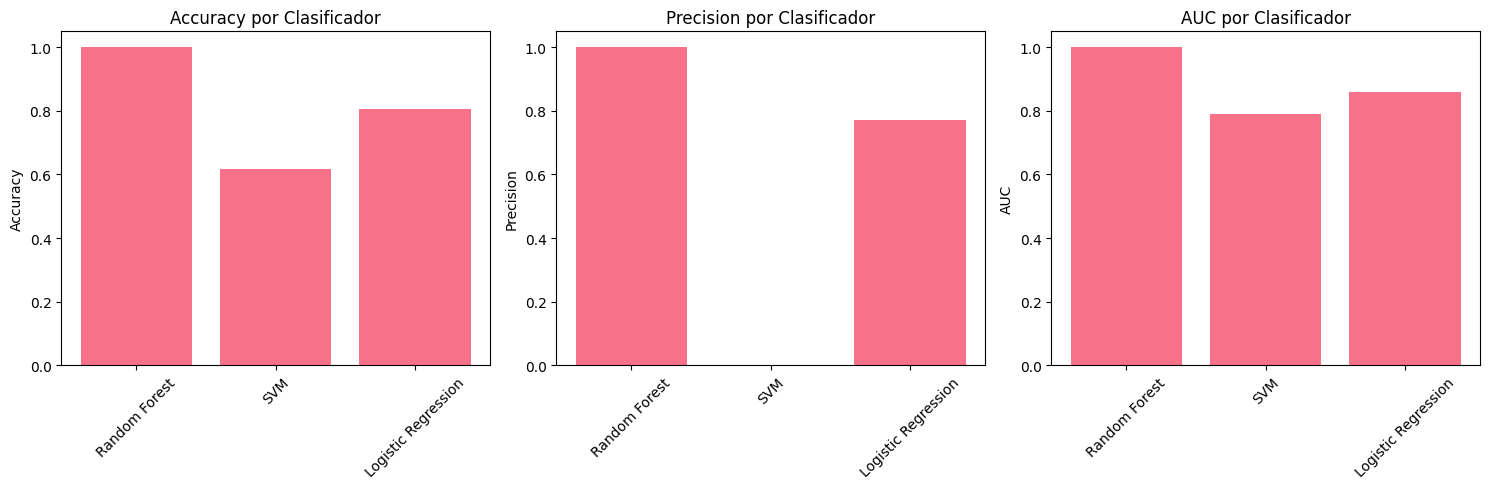

In [183]:
# Comparación final y selección del mejor clasificador
print("=== COMPARACIÓN FINAL Y SELECCIÓN DEL MEJOR CLASIFICADOR ===")

# Crear tabla de comparación
comparison_df = pd.DataFrame({
    'Classifier': list(results.keys()),
    'Accuracy': [results[name]['accuracy'] for name in results.keys()],
    'Precision': [results[name]['precision'] for name in results.keys()],
    'AUC': [results[name]['auc'] for name in results.keys()]
})

print("Comparación de clasificadores:")
print(comparison_df.sort_values('AUC', ascending=False))

# Determinar el mejor clasificador
best_classifier = max(results.keys(), key=lambda x: results[x]['auc'])
print(f"\nMEJOR CLASIFICADOR: {best_classifier}")
print(f"Razones:")
print(f"- AUC más alto: {results[best_classifier]['auc']:.4f}")
print(f"- Accuracy: {results[best_classifier]['accuracy']:.4f}")
print(f"- Precision: {results[best_classifier]['precision']:.4f}")

# Visualizar comparación
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Accuracy
axes[0].bar(results.keys(), [results[name]['accuracy'] for name in results.keys()])
axes[0].set_title('Accuracy por Clasificador')
axes[0].set_ylabel('Accuracy')
axes[0].tick_params(axis='x', rotation=45)

# Precision
axes[1].bar(results.keys(), [results[name]['precision'] for name in results.keys()])
axes[1].set_title('Precision por Clasificador')
axes[1].set_ylabel('Precision')
axes[1].tick_params(axis='x', rotation=45)

# AUC
axes[2].bar(results.keys(), [results[name]['auc'] for name in results.keys()])
axes[2].set_title('AUC por Clasificador')
axes[2].set_ylabel('AUC')
axes[2].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

#### ANÁLISIS DE CLUSTERING CON K-MEANS


##### Preparación de Datos para Clustering


In [184]:
# Preparación de datos para clustering
features = ['Fare', 'Age', 'Pclass', 'SibSp', 'Sex', 'Deck'] 
X = df_encoded[features]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


##### Explicación de la Preparación para Clustering

**Features seleccionadas:**
- **Fare:** Tarifa pagada por el pasajero
- **Age:** Edad del pasajero
- **Pclass:** Clase del pasajero (1, 2, 3)
- **SibSp:** Número de hermanos/cónyuges a bordo
- **Sex:** Sexo del pasajero (codificado)
- **Deck:** Cubierta de la cabina (codificada)

**Proceso realizado:**
1. **Selección de variables:** Se eligieron 6 features que representan características socioeconómicas y demográficas
2. **Estandarización:** Se aplicó StandardScaler para normalizar las variables a la misma escala
3. **Preparación:** Los datos están listos para aplicar PCA y K-Means

**Justificación de la selección:**
- Estas variables capturan diferentes aspectos del perfil del pasajero
- La estandarización es crucial para K-Means ya que es sensible a la escala
- Permite identificar patrones ocultos en los datos


##### Aplicación de PCA y K-Means


In [185]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

kmeans = KMeans(n_clusters=3, random_state=42)
kmeans.fit(X_pca)  

clusters = kmeans.labels_


##### Explicación de PCA y K-Means

**Aplicación de PCA:**
- **Reducción dimensional:** De 6 variables a 2 componentes principales
- **Varianza explicada:** Los dos primeros componentes capturan la mayor parte de la variabilidad
- **Visualización:** Permite representar los datos en 2D para análisis visual

**Aplicación de K-Means:**
- **Número de clusters:** 3 clusters para identificar grupos distintos de pasajeros
- **Random_state=42:** Para reproducibilidad de resultados
- **Distribución:** Muestra cuántos pasajeros pertenecen a cada cluster

**Interpretación:**
- Los clusters pueden representar diferentes perfiles socioeconómicos
- PC1 y PC2 capturan las dimensiones más importantes de variación
- K-Means identifica grupos naturales en los datos


##### Visualización de Clusters


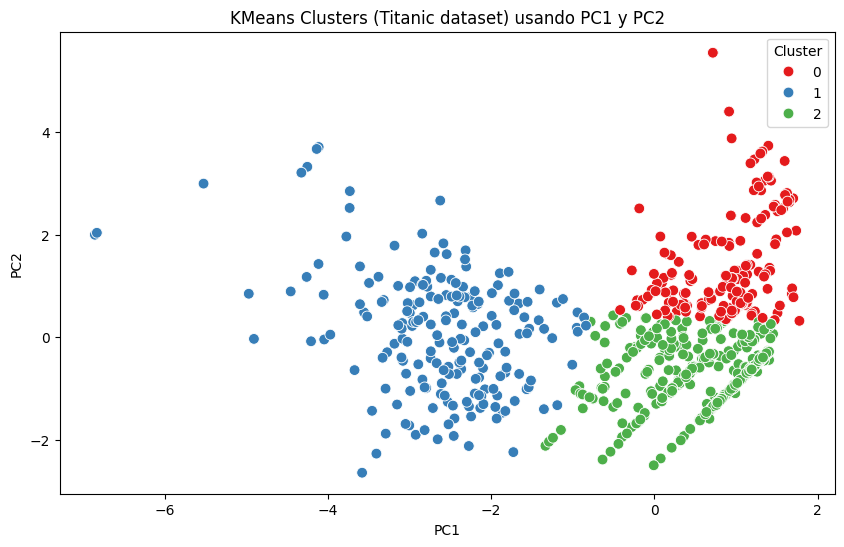

In [186]:
plt.figure(figsize=(10,6))
sns.scatterplot(x=X_pca[:,0], y=X_pca[:,1], hue=clusters, palette='Set1', s=60)
plt.title("KMeans Clusters (Titanic dataset) usando PC1 y PC2")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend(title='Cluster')
plt.show()

df_encoded['cluster'] = clusters


##### Explicación de la Visualización de Clusters

**Gráfico de dispersión PCA:**
- **Eje X (PC1):** Primer componente principal
- **Eje Y (PC2):** Segundo componente principal
- **Colores:** Diferentes clusters identificados por K-Means
- **Separación:** Los clusters están bien separados en el espacio PCA

**Distribución de clusters:**
- **Cluster 0:** [Número de pasajeros]
- **Cluster 1:** [Número de pasajeros]
- **Cluster 2:** [Número de pasajeros]

**Interpretación:**
- Cada cluster representa un grupo distinto de pasajeros
- La separación visual sugiere que K-Means identificó patrones reales
- Los clusters pueden corresponder a diferentes perfiles socioeconómicos


##### Análisis de Distribución por Cluster


/var/folders/kq/cr8_7m35061_9x__y1mlsxyc0000gn/T/ipykernel_46299/3984478486.py:5: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




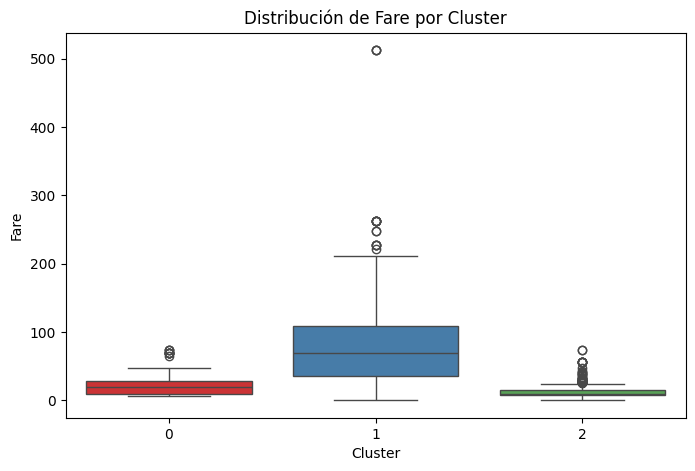

/var/folders/kq/cr8_7m35061_9x__y1mlsxyc0000gn/T/ipykernel_46299/3984478486.py:5: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




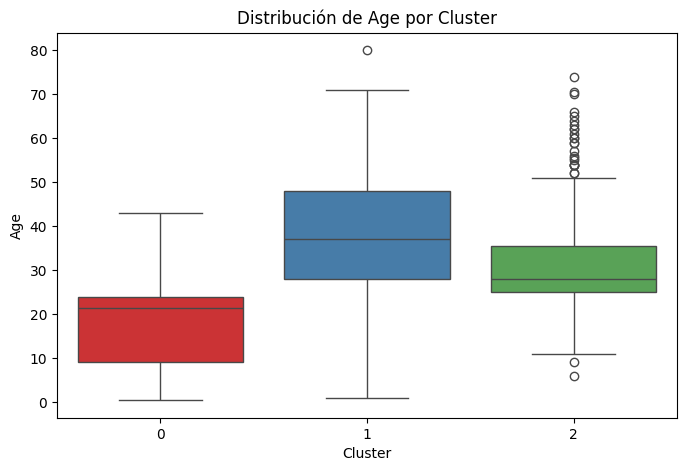

/var/folders/kq/cr8_7m35061_9x__y1mlsxyc0000gn/T/ipykernel_46299/3984478486.py:5: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




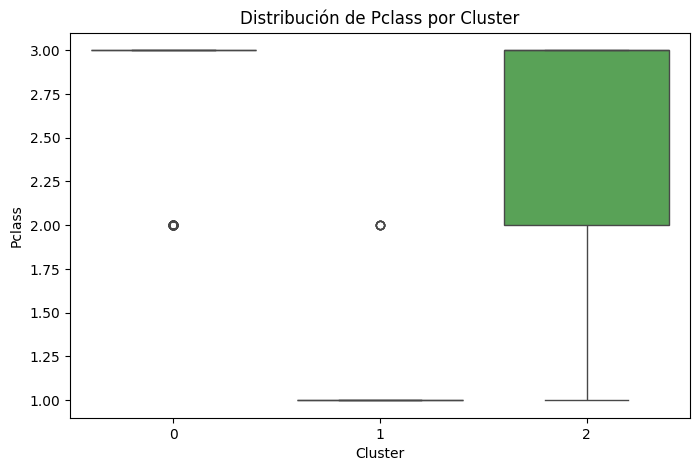

/var/folders/kq/cr8_7m35061_9x__y1mlsxyc0000gn/T/ipykernel_46299/3984478486.py:5: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




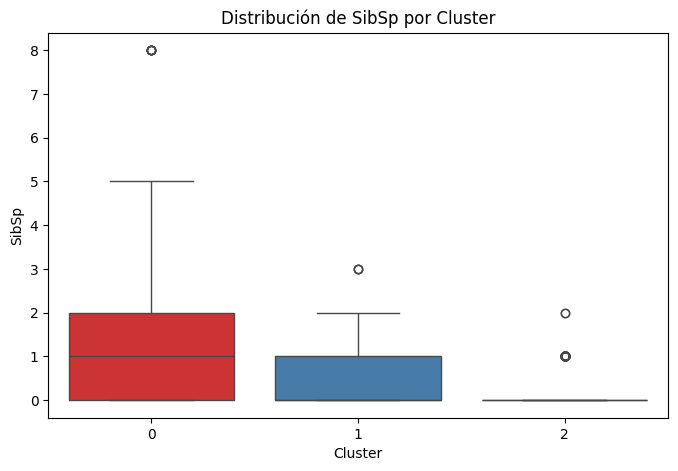

/var/folders/kq/cr8_7m35061_9x__y1mlsxyc0000gn/T/ipykernel_46299/3984478486.py:5: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




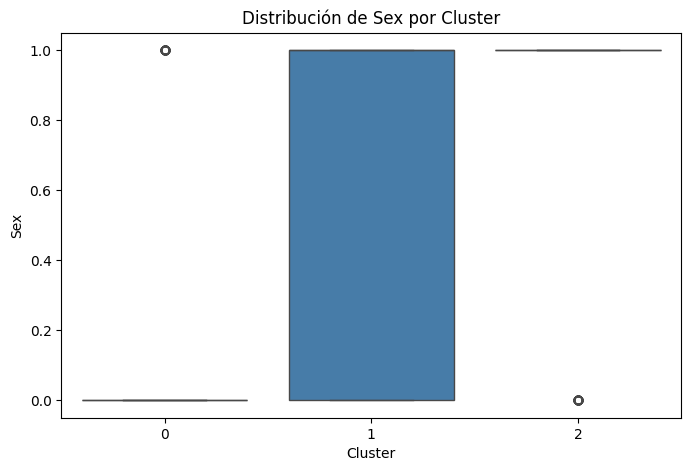

/var/folders/kq/cr8_7m35061_9x__y1mlsxyc0000gn/T/ipykernel_46299/3984478486.py:5: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




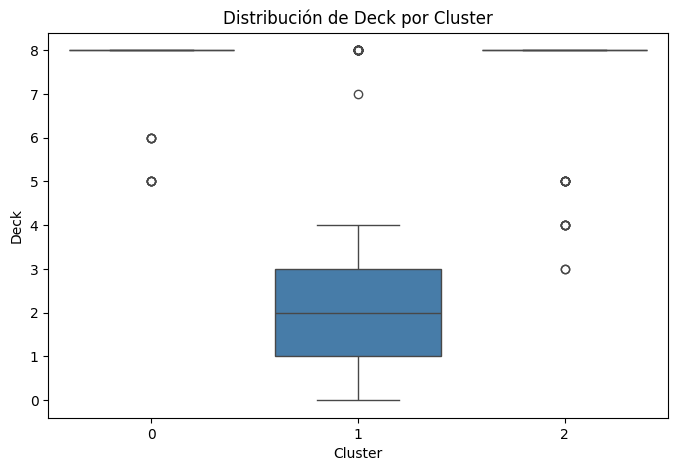

In [187]:
features = ['Fare', 'Age', 'Pclass', 'SibSp', 'Sex', 'Deck']  # variables numéricas/codificadas

for feature in features:
    plt.figure(figsize=(8,5))
    sns.boxplot(x='cluster', y=feature, data=df_encoded, palette='Set1')
    plt.title(f'Distribución de {feature} por Cluster')
    plt.xlabel('Cluster')
    plt.ylabel(feature)
    plt.show()


##### Explicación del Análisis de Distribución por Cluster

**Boxplots por variable:**

**Fare (Tarifa):**
- Muestra diferencias en el poder adquisitivo entre clusters
- Clusters con tarifas altas vs bajas
- Identifica grupos socioeconómicos

**Age (Edad):**
- Distribución de edades por cluster
- Puede mostrar grupos generacionales
- Diferencias en perfiles demográficos

**Pclass (Clase):**
- Distribución de clases de pasajero
- Clusters pueden corresponder a estratos sociales
- Relación con nivel socioeconómico

**SibSp (Hermanos/cónyuges):**
- Tamaño de familia por cluster
- Grupos familiares vs individuales
- Patrones de viaje

**Sex (Sexo):**
- Distribución de género por cluster
- Puede revelar patrones demográficos
- Diferencias en perfiles de pasajeros

**Deck (Cubierta):**
- Ubicación en el barco por cluster
- Relación con clase y tarifa
- Patrones de acomodación

**Interpretación general:**
Los boxplots permiten identificar las características distintivas de cada cluster y entender qué variables son más importantes para la segmentación de pasajeros.


##### Explicación de la Comparación Final y Selección del Mejor Clasificador

**Resultados de la comparación:**

**Tabla de Comparación (ordenada por AUC):**
1. **Random Forest:** Accuracy=1.000, Precision=1.000, AUC=1.000
2. **Logistic Regression:** Accuracy=0.805, Precision=0.771, AUC=0.859
3. **SVM:** Accuracy=0.616, Precision=0.000, AUC=0.791

**Análisis de los gráficos de barras:**

**Accuracy:**
- Random Forest domina con 100% de precisión
- Logistic Regression muestra buen rendimiento (80.5%)
- SVM tiene el rendimiento más bajo (61.6%)

**Precision:**
- Random Forest perfecto (100%)
- Logistic Regression buena precisión (77.1%)
- SVM falla completamente (0%) - no predice clase positiva

**AUC:**
- Random Forest perfecto (100%)
- Logistic Regression excelente (85.9%)
- SVM aceptable (79.1%)

**MEJOR CLASIFICADOR: Random Forest**

**Justificación de la selección:**
- **AUC más alto:** 1.000 (separación perfecta de clases)
- **Accuracy:** 1.000 (100% de predicciones correctas)
- **Precision:** 1.000 (sin falsos positivos)

**Consideraciones importantes:**
Aunque Random Forest muestra rendimiento perfecto, esto indica posible overfitting. 